# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [16]:
!nvidia-smi

Sat Mar 19 15:52:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P2    60W / 240W |    594MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
#from rdkit import Chem
#from rdkit.Chem import AllChem

In [19]:
dataset = 'CHEMBL205'

In [20]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/dataset/f'{dataset}_train_valid.csv')

In [21]:
list(path.iterdir())

[Path('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205'),
 Path('../dataset/13321_2017_226_MOESM1_ESM/.ipynb_checkpoints'),
 Path('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301'),
 Path('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218'),
 Path('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219'),
 Path('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244'),
 Path('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 Path('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978'),
 Path('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240')]

In [22]:
DATA = path/'mol_images'

In [23]:
IMAGES = DATA/dataset

# Create train validation split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [26]:
len(df[df.is_valid == True]) / len(df[df.is_valid == False])

0.2500696767001115

# Create dataloader

In [27]:
from fastai.vision.all import *

In [28]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png


In [29]:
images = df['CID'] + ".png"
images.head()

0     CHEMBL188002.png
1     CHEMBL364127.png
2    CHEMBL1683469.png
3      CHEMBL52564.png
4      CHEMBL21427.png
Name: CID, dtype: object

In [30]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [31]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=None,
    )

Oversmaple instead of using class weights to test custom loss function

In [32]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df


In [33]:
def get_df(dataset, random_state=42, test_size=0.25, oversample=True):
    df = pd.read_csv(path/dataset/f'{dataset}_cl.csv')
    df = val_cols_and_oversample(df, test_size=test_size, random_state=random_state, oversample=oversample)
    df['Image'] = df['CID'] + '.png'
    return df

In [34]:
def get_df_with_clusters(dataset, n_clusters=100, random_state=42, test_size=0.25):
    df = pd.read_csv(path/dataset/f'{dataset}_cl_ECFP_1024_with_{n_clusters}_clusters.csv')
    values = df.Cluster.value_counts(ascending=True)
    values = values[values < 2].index
    for i in list(values):
        df = df.drop(df[df.Cluster == i].index)
    df.reset_index(drop=True, inplace=True)
    x_train, x_valid = train_test_split(df.index, test_size=test_size, random_state=random_state, stratify=df['Cluster'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['Name'] + '.png'
    return df

In [35]:
df = get_df(dataset)
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
1,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
2,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
3,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png
4,CHEMBL1414,O(C)c1cc(cc(OC)c1O)C(=O)[O-],1,False,CHEMBL1414.png


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28948 entries, 0 to 28947
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       28948 non-null  object
 1   SMILES    28948 non-null  object
 2   Activity  28948 non-null  int64 
 3   is_valid  28948 non-null  object
 4   Image     28948 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [37]:
IMAGES = DATA/f'{dataset}_cl'
IMAGES

Path('../dataset/13321_2017_226_MOESM1_ESM/mol_images/CHEMBL205_cl')

In [38]:
def get_dls(dataset, bs=64, clustering=False, random_state=42):
    IMAGES = DATA/f'{dataset}_cl'
    if clustering:
        df = get_df_with_clusters(dataset, n_clusters=100)
    else: 
        df = get_df(dataset, oversample=True)
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=None,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True, random_state=42, num_workers=0)
    return dls, df

In [39]:
dls, df = get_dls(dataset, clustering=False)

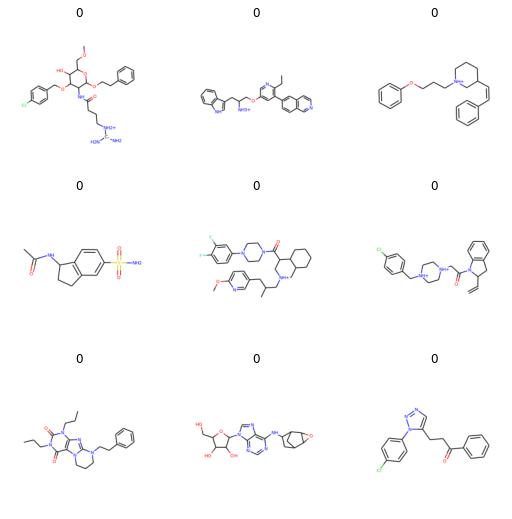

In [40]:
dls.show_batch()

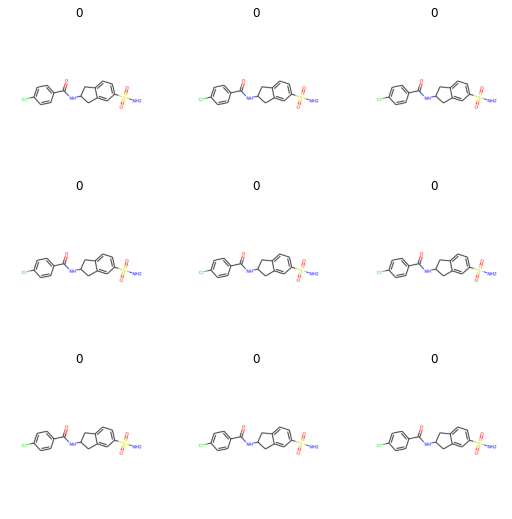

In [41]:
dls.show_batch(unique=True)

# Create class weights

In [42]:
TARGET = 'Activity'

In [43]:
train_df = df[df.is_valid == False]

In [44]:
class_count_df = train_df.groupby(TARGET).count()
class_count_df

,CID,SMILES,is_valid,Image
Activity,,,,
0,12232,12232,12232,12232
1,12230,12230,12230,12230


In [45]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [46]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0, w_1

(0.9999182472204055, 1.0000817661488144)

In [47]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [48]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [49]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [50]:
loss_func=get_loss_func(df)

# Train CNN model

In [51]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
from utils.losses import * 

In [52]:
from fastai.callback.hook import *

In [53]:
def train_model(dls, arch=resnet18, loss_func=None, metric = None, epochs=5, wd=None, lr=None):
    losses = []
    mets = []
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    if metric == None: 
        learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()], cbs=ShowGraphCallback())
    else: 
        learn = cnn_learner(dls, arch=arch, pretrained=True, 
                                wd=wd,
                                loss_func=loss_func,
                                metrics=[accuracy, 
                                F1Score(), 
                                Precision(), 
                                Recall(), 
                                RocAucBinary(), 
                                MatthewsCorrCoef(), 
                                metric]).to_fp16()
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    
    learn.fine_tune(epochs, lr)
    
    
    return learn

In [55]:
learn = cnn_learner(dls, arch=resnet18, pretrained=True, 
                            wd=None,
                            loss_func=None,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])


In [56]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [54]:
# Train model on resnet18
learn = train_model(dls,loss_func=None, epochs=5, lr=3e-3, wd=0.002)

Architechture: <function resnet18 at 0x7f6bd8475a70>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


IndexError: list index out of range

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(k=50)

# Test for metric with cost

In [43]:
cost = [100, 1]

In [44]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [45]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0 = w_0 * cost[0]
w_1 = w_1 * cost[1]
w_0, w_1

(99.99182472204055, 1.0000817661488144)

In [46]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [47]:
decision_loss = nn.CrossEntropyLoss(weight=class_weights)
type(decision_loss)

torch.nn.modules.loss.CrossEntropyLoss

In [48]:
type(F1Score())

fastai.metrics.AccumMetric

In [49]:
# Train model on resnet18
learn = train_model(dls,loss_func=loss_func, metric=decision_loss, epochs=1, lr=3e-3, wd=0.002)

Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=1
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,None,time
0,0.229574,0.321096,0.897013,0.616279,0.466080,0.909314,0.961278,0.605943,0.322096,01:24


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,None,time
0,0.070795,0.122036,0.967900,0.837472,0.776151,0.909314,0.982980,0.822950,0.122370,01:40


In [50]:
interp = ClassificationInterpretation.from_learner(learn)

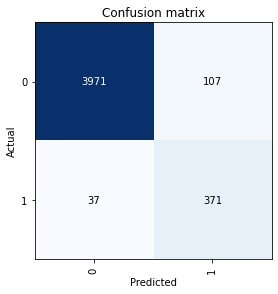

In [51]:
interp.plot_confusion_matrix()

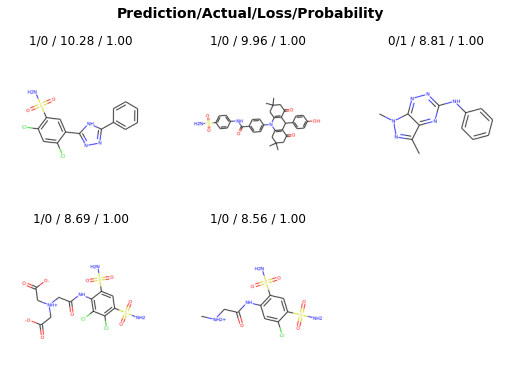

In [52]:
interp.plot_top_losses(k=5)

In [61]:
def show_confusion_matrix(learn, dl):
    preds, y = learn.get_preds(dl=dl)
    pred = preds.argmax(axis=1)
    cm = confusion_matrix(y, pred)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

# Cost-sensitive loss function



There's a simple idea behind a Cost-Sensitive Loss: we impose a different penalty to different kind of errors. For illustration purposes, imagine you have a three-class classification problem and you wish to impose a greater penalty to errors in misclassifying class 2 as class 0, but you don't care about the other errors.*

In [53]:
import torch
from torch import nn
import torch.nn.functional as F

In [54]:
n_classes = 2

In [55]:
cs_loss = CostSensitiveLoss(n_classes, normalization='sigmoid')

In [56]:
print(cs_loss.M)

tensor([[0., 1.],
        [1., 0.]])


In [57]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
cs_loss.M = M


In [58]:
print(cs_loss.M)

tensor([[0.0000, 1.0000],
        [0.1000, 0.0000]])


In [59]:
# Train model on resnet18
learn = train_model(dls,loss_func=cs_loss, metric=cs_loss, epochs=1, lr=3e-3, wd=0.002)

Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=1
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,None,time
0,0.008239,0.006241,0.929336,0.636884,0.597849,0.681373,0.940932,0.599497,0.006241,01:25


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,None,time
0,0.002227,0.001439,0.933125,0.592391,0.664634,0.534314,0.929524,0.560368,0.001439,01:41


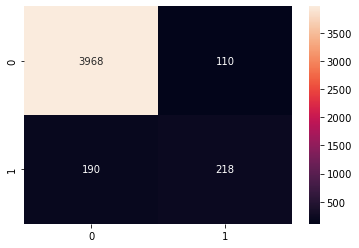

<AxesSubplot:>

In [63]:
show_confusion_matrix(learn, dls.valid)

**Results**: Just training for 1 epoch, number of False Positives went down, number of False Negatives went up (as expected), but number of True positives also went down which is bad. 

# Regularized cost-sensitive loss function

In our experiments (and elsewhere) we found out that simply using a CS loss leads to lots of trouble in terms of CNNs staying at local minima where they will predict a trivial configuration (all the time the same category), which seems to be very satisfying for this kind of losses. For this reason, we recommend using this as a regularizer for other standard classification losses (just a weighted sum of both, with a weighing parameter `lambd`). \
In our implementation we provide a wrapper for doing this, where you specify a `base_loss` and the regularization parameter `lambd`:


In [64]:
n_classes = 2 
base_loss = 'ce'
lambd = 10
cs_regularized_loss = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)

In [65]:
print(cs_regularized_loss.M)

tensor([[0., 1.],
        [1., 0.]])


In [66]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
cs_regularized_loss.M = M

In [67]:
print(cs_regularized_loss.M)

tensor([[0.0000, 1.0000],
        [0.1000, 0.0000]])


In [ ]:
# Train model on resnet18
learn = train_model(dls,loss_func=cs_regularized_loss, metric=cs_regularized_criterion, epochs=1, lr=3e-3, wd=0.002)

In [ ]:
preds, y = learn.get_preds(dl=dls.valid)

In [ ]:
preds

In [50]:
def show_confusion_matrix(learn, dl):
    preds, y = learn.get_preds(dl=dl)
    pred = preds.argmax(axis=1)
    cm = confusion_matrix(y, pred)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

In [ ]:
show_confusion_matrix(learn, dls.valid)

**Results**:  False positives went drastically down, and true positives up compared to just using cost-sensitive loss, precision is higher then using regular cross entropy loss so could be a bit random. 

### Train for 10 epochs: 

In [ ]:
learn = train_model(dls,loss_func=cs_regularized_loss, metric=cs_regularized_criterion, epochs=10, lr=3e-3, wd=0.002)

In [ ]:
show_confusion_matrix (learn, dls)

# Compare regularized cost-sensitive loss functions

In [44]:
from utils.losses import *

Compare: Cross entropy (CE), CE with Label Smoothing (LS), CE with Gaussian LS

In [74]:
losses = ['ce']

In [128]:
M = np.array([[0,10],
            [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)

In [126]:
def train_model_with_loss(base_loss='ce', n_classes = 2, lambd = 10):
    loss = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)
    loss.M = M
    learn = train_model(dls,loss_func=loss, epochs=10, lr=3e-3, wd=0.002)
    cm = show_confusion_matrix(learn, dls.valid)
    return learn, cm

In [112]:
recorders = []

In [113]:
logs = []

Training model with base loss function ce and lambd: 10
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.724984,0.671954,0.946723,0.741622,0.663443,0.840686,0.965766,0.718589,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.296038,0.346091,0.964111,0.800000,0.811083,0.789216,0.974846,0.780378,01:28
1,0.147529,0.333376,0.970352,0.838002,0.832930,0.843137,0.980438,0.821705,01:28
2,0.047226,0.279823,0.971690,0.838628,0.870712,0.808824,0.983105,0.823807,01:28


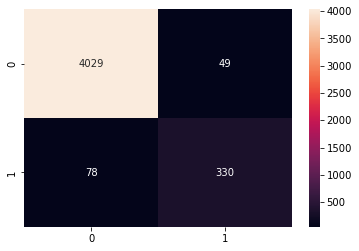

In [116]:
lambd = 10
for l in losses:
    if l == 'gls':
        lambd = 2
    print(f'Training model with base loss function {l} and lambd: {lambd}')
    base_loss = l
    model, _ = train_model_with_loss(base_loss=base_loss, lambd=lambd)
    recorders.append(model)

In [117]:
log = recorders[0].recorder.after_epoch()
log

[0, 0.27982261776924133, 0.9716897010803223, 0.8386277001270648, 0.8707124010554089, 0.8088235294117647, 0.9831051842021753, 0.8238067231495001, '00:07', '00:43']


In [118]:
interp = ClassificationInterpretation.from_learner(recorders[0])

In [119]:
interp.plot_top_losses(k=5)

TypeError: no implementation found for 'torch.Tensor.__getitem__' on types that implement __torch_function__: [TensorImage, TensorCategory]

# Test different lambdas

Lamdas is used to choose how much you will weight the cost-sensitive loss functions vs cross-entropy

In [61]:
lambdas = [0, 0.1, 1, 10]
lambdas

[0, 0.1, 1, 10]

In [124]:
learners = []

Training model with base loss function ce and lambda: 0
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.248337,0.248303,0.915961,0.666076,0.521498,0.921569,0.968122,0.655258,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.102976,0.173708,0.954079,0.785417,0.682971,0.924020,0.978593,0.771250,01:28
1,0.047397,0.124903,0.968346,0.832547,0.802273,0.865196,0.979754,0.815804,01:27
2,0.006592,0.128534,0.972358,0.850602,0.836493,0.865196,0.980407,0.835522,01:27


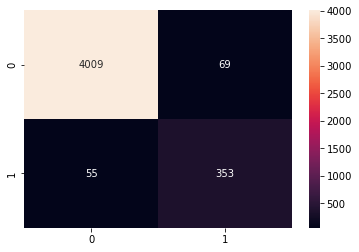

Training model with base loss function ce and lambda: 0.1
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.251786,0.211173,0.934240,0.707631,0.594010,0.875000,0.968206,0.688125,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.098996,0.171999,0.958092,0.801268,0.704461,0.928922,0.978924,0.787645,01:28
1,0.041126,0.129994,0.970352,0.839952,0.825059,0.855392,0.981117,0.823784,01:28
2,0.009406,0.135220,0.972358,0.853774,0.822727,0.887255,0.984359,0.839263,01:28


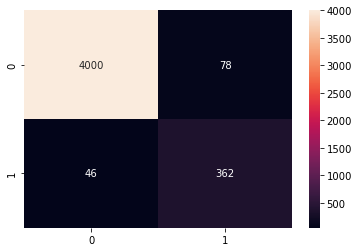

Training model with base loss function ce and lambda: 1
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.319560,0.253932,0.940259,0.724280,0.624113,0.862745,0.968502,0.703157,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.119226,0.246676,0.955417,0.790356,0.690476,0.924020,0.979953,0.776180,01:28
1,0.051399,0.169713,0.968792,0.830508,0.820574,0.840686,0.977612,0.813397,01:28
2,0.011433,0.163821,0.972136,0.848851,0.837709,0.860294,0.981127,0.833597,01:28


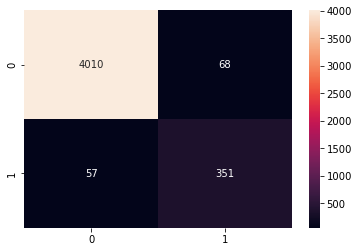

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.711179,0.597568,0.950513,0.747153,0.697872,0.803922,0.964164,0.722090,01:13


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.294818,0.439490,0.967900,0.833718,0.788210,0.884804,0.976622,0.817689,01:27
1,0.122806,0.274572,0.969906,0.826255,0.869919,0.786765,0.976388,0.811052,01:27
2,0.034187,0.291948,0.971021,0.835859,0.861979,0.811275,0.980205,0.820435,01:27


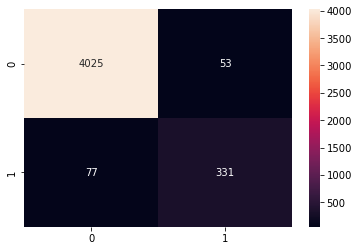

In [122]:
n_classes = 2
base_loss = 'ce'
for l in lambdas:
    print(f'Training model with base loss function {base_loss} and lambda: {l}')
    learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
    learners.append(learn)

Training model with base loss function focal_loss and lambda: 0
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.051926,0.043659,0.897236,0.611626,0.465982,0.889706,0.946889,0.597904,01:13


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.018104,0.018760,0.958538,0.795604,0.721116,0.887255,0.981561,0.777952,01:25
1,0.010570,0.023790,0.963442,0.810624,0.766376,0.860294,0.970447,0.792084,01:25
2,0.005971,0.017391,0.968123,0.824108,0.827160,0.821078,0.978872,0.806588,01:27
3,0.002116,0.023751,0.971467,0.841975,0.848259,0.835784,0.981665,0.826321,01:26
4,0.000442,0.026949,0.972581,0.850547,0.843373,0.857843,0.981919,0.835491,01:26


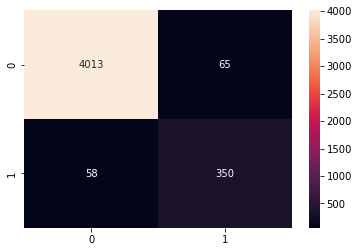

Training model with base loss function focal_loss and lambda: 0.1
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.068379,0.046536,0.925546,0.679463,0.558360,0.867647,0.962426,0.659485,01:13


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.025245,0.035954,0.954525,0.784355,0.689591,0.909314,0.975604,0.768555,01:27
1,0.017739,0.030146,0.970575,0.846868,0.803965,0.894608,0.982035,0.832093,01:27
2,0.008289,0.032693,0.969015,0.836663,0.803612,0.872549,0.982500,0.820426,01:28
3,0.002576,0.039443,0.972804,0.854067,0.834112,0.875000,0.983602,0.839373,01:28
4,0.001002,0.040861,0.973027,0.855090,0.836066,0.875000,0.982612,0.840493,01:28


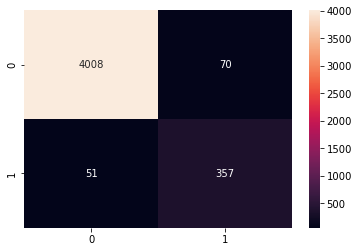

Training model with base loss function focal_loss and lambda: 1
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.115090,0.112421,0.944494,0.733119,0.651429,0.838235,0.967018,0.709647,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.048780,0.086238,0.958538,0.787671,0.737179,0.845588,0.973911,0.767027,01:28
1,0.040359,0.058120,0.966117,0.817746,0.800469,0.835784,0.981493,0.799304,01:28
2,0.022513,0.065449,0.968123,0.835821,0.786177,0.892157,0.982964,0.820253,01:28
3,0.004387,0.071922,0.969683,0.827411,0.857895,0.799020,0.982811,0.811432,01:28
4,0.002011,0.072780,0.972581,0.848335,0.853598,0.843137,0.983405,0.833283,01:29


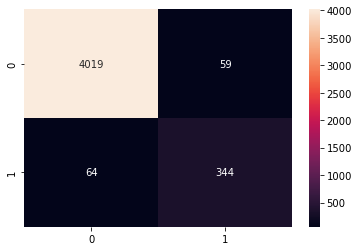

Training model with base loss function focal_loss and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.516483,0.377467,0.950736,0.725466,0.735516,0.715686,0.959523,0.698490,01:15


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.207415,0.337067,0.965225,0.817330,0.782511,0.855392,0.980895,0.799122,01:33
1,0.160206,0.214980,0.964111,0.790091,0.844011,0.742647,0.974986,0.772442,01:34
2,0.097554,0.226332,0.971467,0.841584,0.850000,0.833333,0.977839,0.825956,01:34
3,0.030481,0.200747,0.969906,0.825806,0.871935,0.784314,0.979327,0.810747,01:33
4,0.009017,0.204683,0.970575,0.832911,0.861257,0.806373,0.979433,0.817330,01:35


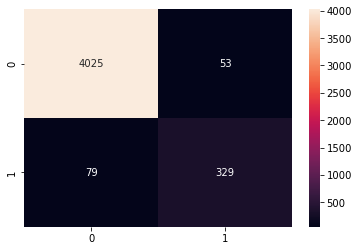

In [68]:
n_classes = 2
base_loss = 'focal_loss'
for l in lambdas:
    print(f'Training model with base loss function {base_loss} and lambda: {l}')
    learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
    learners.append(learn)

Training model with base loss function ls and lambda: 0
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=10
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.385948,0.384301,0.899911,0.627386,0.474279,0.926471,0.961864,0.619658,01:25


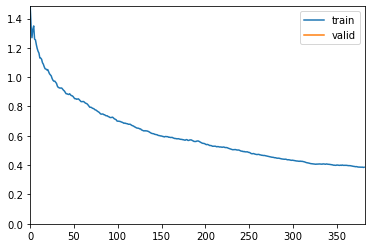

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.244635,0.266022,0.970129,0.843458,0.805804,0.884804,0.980515,0.828092,01:41
1,0.237951,0.263037,0.969461,0.843786,0.788913,0.906863,0.983141,0.829418,01:41
2,0.234445,0.258767,0.971690,0.848268,0.827506,0.870098,0.977468,0.832986,01:41
3,0.221382,0.255796,0.972358,0.852029,0.830233,0.875000,0.973922,0.837147,01:41
4,0.213798,0.257660,0.971244,0.844391,0.831354,0.857843,0.974705,0.828677,01:42
5,0.208742,0.257374,0.971467,0.840399,0.855330,0.825980,0.973537,0.824889,01:41
6,0.205012,0.253534,0.972136,0.845488,0.852868,0.838235,0.976148,0.830214,01:41
7,0.203215,0.254538,0.971467,0.842365,0.846535,0.838235,0.974666,0.826691,01:42
8,0.203373,0.253589,0.973250,0.853659,0.849515,0.857843,0.974851,0.838951,01:38
9,0.203155,0.253625,0.971467,0.841191,0.851759,0.830882,0.974837,0.825596,01:38


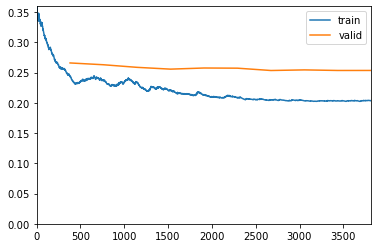

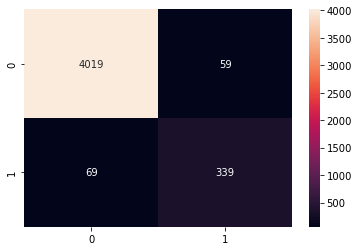

Training model with base loss function ls and lambda: 0.1
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=10
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.389265,0.360782,0.922648,0.674178,0.546423,0.879902,0.967112,0.656158,01:22


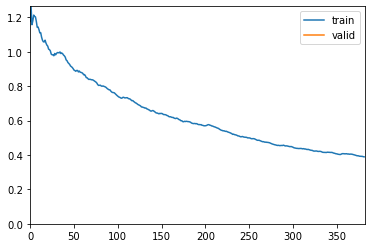

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.253810,0.271050,0.971021,0.844498,0.824766,0.865196,0.980301,0.828818,01:37
1,0.247023,0.272078,0.970575,0.848276,0.798701,0.904412,0.978444,0.834024,01:38
2,0.234636,0.306056,0.951850,0.775934,0.672662,0.916667,0.976000,0.760948,01:37
3,0.226247,0.261781,0.972136,0.851720,0.825287,0.879902,0.970231,0.836883,01:38
4,0.221832,0.278298,0.969015,0.843292,0.780793,0.916667,0.972007,0.829496,01:38
5,0.214847,0.260983,0.970575,0.837838,0.839901,0.835784,0.973672,0.821661,01:38
6,0.207750,0.260658,0.972136,0.848485,0.839329,0.857843,0.973340,0.833204,01:37
7,0.206352,0.261199,0.972358,0.849515,0.841346,0.857843,0.972777,0.834345,01:37
8,0.207598,0.263890,0.970798,0.836454,0.852417,0.821078,0.970019,0.820602,01:37
9,0.206640,0.260657,0.973473,0.855758,0.846523,0.865196,0.970097,0.841214,01:37


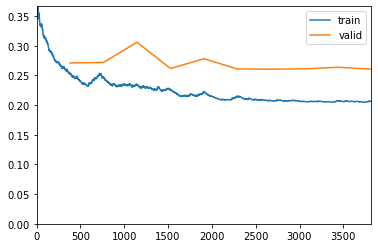

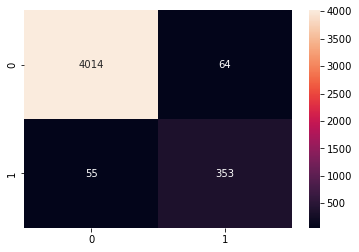

Training model with base loss function ls and lambda: 1
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=10
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.467705,0.463925,0.931788,0.702335,0.582258,0.884804,0.967441,0.684266,01:22


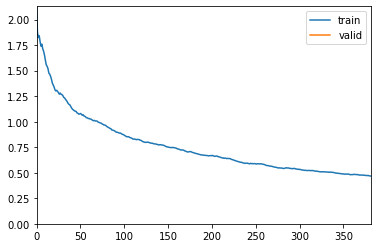

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.294036,0.319104,0.969683,0.830846,0.843434,0.818627,0.977032,0.814309,01:38
1,0.279968,0.331061,0.969683,0.841860,0.800885,0.887255,0.978075,0.826467,01:37
2,0.264803,0.325969,0.966340,0.827033,0.776344,0.884804,0.979275,0.810598,01:37
3,0.252228,0.311382,0.971467,0.845036,0.834928,0.855392,0.961271,0.829399,01:37
4,0.240643,0.315051,0.969238,0.834532,0.816901,0.852941,0.978077,0.817815,01:37
5,0.234522,0.311745,0.971467,0.845411,0.833333,0.857843,0.971507,0.829803,01:37
6,0.227939,0.305732,0.971244,0.838951,0.854962,0.823529,0.973470,0.823344,01:38
7,0.225912,0.307338,0.970575,0.836634,0.845000,0.828431,0.974446,0.820515,01:38
8,0.224164,0.305011,0.971244,0.839752,0.851385,0.828431,0.971744,0.824052,01:37
9,0.224181,0.304936,0.972136,0.845869,0.851117,0.840686,0.973145,0.830572,01:37


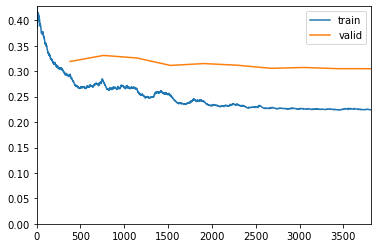

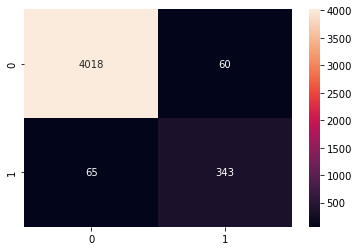

Training model with base loss function ls and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=10
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.985605,0.843479,0.952965,0.746089,0.732861,0.759804,0.954328,0.720323,01:22


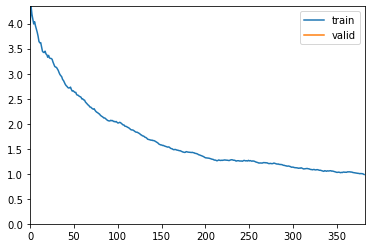

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.503335,0.606919,0.967677,0.815287,0.848806,0.784314,0.973107,0.798354,01:38
1,0.436282,0.590009,0.969683,0.834146,0.830097,0.838235,0.980887,0.817476,01:37
2,0.426912,0.567050,0.967008,0.811705,0.843915,0.781863,0.971666,0.794349,01:37
3,0.372790,0.542971,0.970575,0.832487,0.863158,0.803922,0.960883,0.817001,01:37
4,0.342287,0.535569,0.966340,0.800528,0.868195,0.742647,0.937867,0.785116,01:37
5,0.314878,0.568492,0.971244,0.845509,0.826698,0.865196,0.962018,0.829926,01:37
6,0.314179,0.549949,0.969683,0.828283,0.854167,0.803922,0.960706,0.812122,01:37
7,0.295486,0.540797,0.968123,0.819672,0.844156,0.796569,0.970220,0.802611,01:37
8,0.291706,0.527063,0.968346,0.813648,0.875706,0.759804,0.967680,0.798844,01:37
9,0.286252,0.527618,0.969015,0.819715,0.870523,0.774510,0.966723,0.804469,01:37


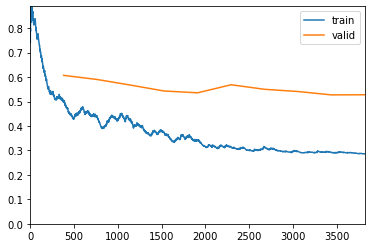

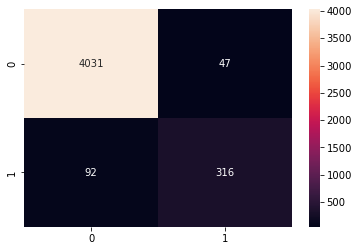

In [129]:
n_classes = 2
base_loss = 'ls'
for l in lambdas:
    print(f'Training model with base loss function {base_loss} and lambda: {l}')
    learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
    learners.append(learn)

Training model with base loss function gls and lambda: 0
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=10
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.367083,0.335571,0.909050,0.000000,0.000000,0.000000,0.594499,0.000000,01:22


/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


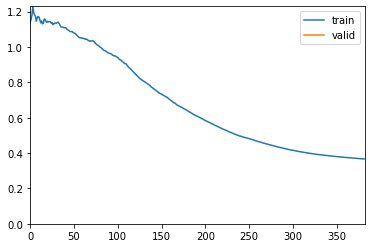

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.338099,0.332469,0.909050,0.000000,0.000000,0.000000,0.435880,0.000000,01:37
1,0.335697,0.332209,0.909050,0.000000,0.000000,0.000000,0.563419,0.000000,01:37
2,0.336707,0.332359,0.909050,0.000000,0.000000,0.000000,0.458573,0.000000,01:38
3,0.335685,0.332560,0.909050,0.000000,0.000000,0.000000,0.275235,0.000000,01:37
4,0.333928,0.331788,0.909050,0.000000,0.000000,0.000000,0.671341,0.000000,01:37
5,0.332728,0.331267,0.909050,0.000000,0.000000,0.000000,0.305291,0.000000,01:38
6,0.332236,0.331120,0.909050,0.000000,0.000000,0.000000,0.590551,0.000000,01:37
7,0.332101,0.331017,0.909050,0.000000,0.000000,0.000000,0.528989,0.000000,01:37
8,0.332011,0.331025,0.909050,0.000000,0.000000,0.000000,0.486421,0.000000,01:37
9,0.331880,0.330952,0.909050,0.000000,0.000000,0.000000,0.516148,0.000000,01:37


/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


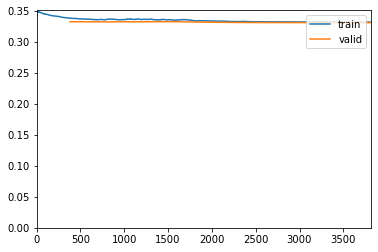

/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib

/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


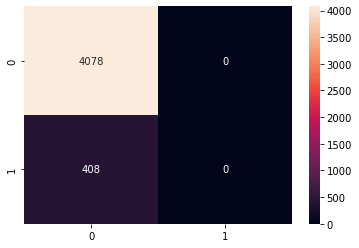

Training model with base loss function gls and lambda: 0.1
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=10
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.377069,0.347628,0.909050,0.000000,0.000000,0.000000,0.626968,0.000000,01:22


/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


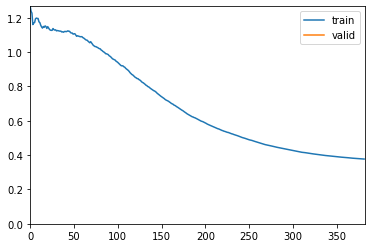

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.349064,0.343167,0.909050,0.000000,0.000000,0.000000,0.673437,0.000000,01:38
1,0.346230,0.343142,0.909050,0.000000,0.000000,0.000000,0.728581,0.000000,01:37
2,0.347430,0.343350,0.909050,0.000000,0.000000,0.000000,0.710810,0.000000,01:37
3,0.345596,0.343960,0.909050,0.000000,0.000000,0.000000,0.833899,0.000000,01:38
4,0.344960,0.342846,0.909050,0.000000,0.000000,0.000000,0.773947,0.000000,01:38
5,0.343753,0.342193,0.909050,0.000000,0.000000,0.000000,0.885473,0.000000,01:37
6,0.342895,0.342344,0.909050,0.000000,0.000000,0.000000,0.941085,0.000000,01:37
7,0.342640,0.342166,0.909050,0.000000,0.000000,0.000000,0.939363,0.000000,01:38
8,0.342267,0.342202,0.909050,0.000000,0.000000,0.000000,0.940935,0.000000,01:37
9,0.342130,0.342150,0.909050,0.000000,0.000000,0.000000,0.936268,0.000000,01:38


/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


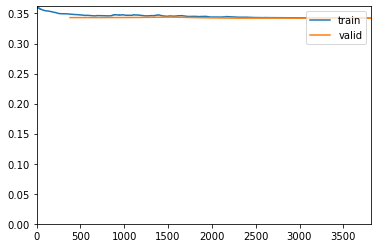

/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib

/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


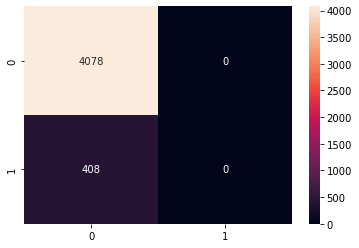

Training model with base loss function gls and lambda: 1
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=10
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.466788,0.422804,0.909050,0.000000,0.000000,0.000000,0.851064,0.000000,01:22


/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


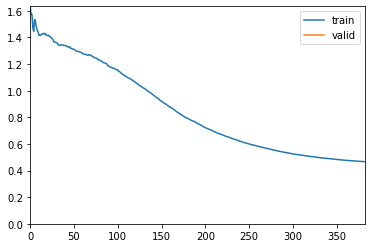

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.428188,0.417271,0.909050,0.000000,0.000000,0.000000,0.947125,0.000000,01:38
1,0.424537,0.417223,0.909050,0.000000,0.000000,0.000000,0.948088,0.000000,01:37
2,0.423738,0.417672,0.909050,0.000000,0.000000,0.000000,0.972692,0.000000,01:38
3,0.420696,0.415126,0.909050,0.000000,0.000000,0.000000,0.975271,0.000000,01:38
4,0.419362,0.415817,0.909050,0.000000,0.000000,0.000000,0.975098,0.000000,01:38
5,0.418768,0.415001,0.909050,0.000000,0.000000,0.000000,0.980017,0.000000,01:37
6,0.418179,0.414920,0.909050,0.000000,0.000000,0.000000,0.976803,0.000000,01:38
7,0.417880,0.414540,0.909050,0.000000,0.000000,0.000000,0.978234,0.000000,01:37
8,0.417399,0.414589,0.909050,0.000000,0.000000,0.000000,0.978595,0.000000,01:38
9,0.417308,0.414560,0.909050,0.000000,0.000000,0.000000,0.979101,0.000000,01:38


/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


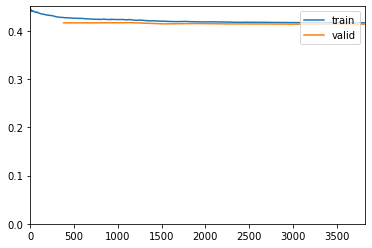

/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib

/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


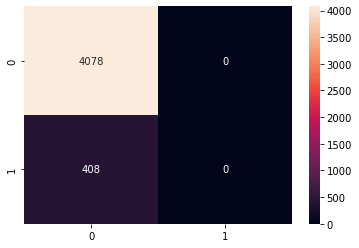

Training model with base loss function gls and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=10
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.071355,0.734961,0.913286,0.097448,0.913043,0.051471,0.924491,0.205247,01:22


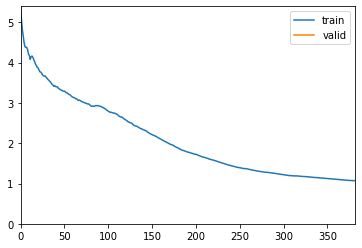

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.947675,0.709360,0.911280,0.052381,0.916667,0.026961,0.978422,0.148723,01:38
1,0.919841,0.696532,0.910165,0.024213,1.000000,0.012255,0.975589,0.105607,01:38
2,0.905105,0.697470,0.910388,0.033654,0.875000,0.017157,0.950314,0.115253,01:38
3,0.885654,0.715707,0.910165,0.024213,1.000000,0.012255,0.975768,0.105607,01:38
4,0.878779,0.690584,0.909050,0.000000,0.000000,0.000000,0.961040,0.000000,01:37
5,0.872446,0.694237,0.909050,0.000000,0.000000,0.000000,0.972622,0.000000,01:37
6,0.867820,0.684649,0.909050,0.000000,0.000000,0.000000,0.964371,0.000000,01:37
7,0.864711,0.690962,0.909050,0.000000,0.000000,0.000000,0.967683,0.000000,01:37
8,0.860190,0.685385,0.909050,0.000000,0.000000,0.000000,0.965353,0.000000,01:38
9,0.863819,0.686176,0.909050,0.000000,0.000000,0.000000,0.970627,0.000000,01:38


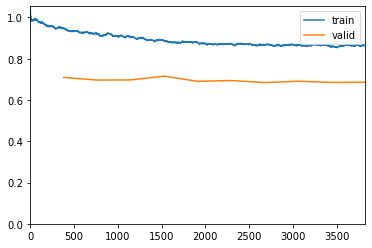

/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kjetil/anaconda3/envs/fastai-drug/lib

/home/kjetil/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


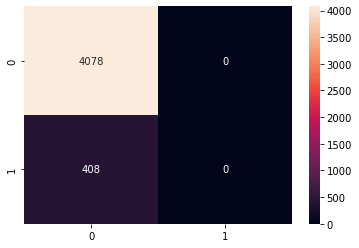

In [130]:
n_classes = 2
base_loss = 'gls'
for l in lambdas:
    print(f'Training model with base loss function {base_loss} and lambda: {l}')
    train_model_with_loss(base_loss=base_loss, lambd=l)
    learners.append(learn)

## Test for different Cost Matrices

In [45]:
M = np.array([[0,1],
            [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.259602,1.194937,0.926661,0.692236,0.559758,0.906863,0.968938,0.677776,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.486771,0.651485,0.964111,0.821310,0.750507,0.906863,0.979613,0.805994,01:27
1,0.376458,0.758381,0.958761,0.801289,0.713193,0.914216,0.972310,0.786149,01:27
2,0.204269,0.490568,0.970798,0.847851,0.805740,0.894608,0.978106,0.833142,01:28
3,0.091801,0.484341,0.971690,0.851809,0.812918,0.894608,0.981636,0.837370,01:26
4,0.046832,0.457778,0.972804,0.853012,0.838863,0.867647,0.979606,0.838178,01:26


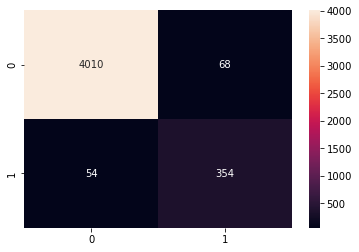

NameError: name 'logs' is not defined

In [51]:
n_classes = 2
base_loss = 'ce'
print(f'Training model with base loss function {base_loss} and lambda: 10')
learn, _ = train_model_with_loss(base_loss=base_loss, lambd=10)
logs.append(learn)

In [53]:
M = np.array([[0,10],
            [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.705779,0.568676,0.954971,0.767281,0.723913,0.816176,0.963026,0.744091,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.250514,0.578741,0.956754,0.785398,0.715726,0.870098,0.970340,0.766098,01:28
1,0.245765,0.339994,0.971467,0.844660,0.836538,0.852941,0.982504,0.829000,01:27
2,0.135807,0.367004,0.968792,0.832134,0.814554,0.850490,0.975940,0.815171,01:27
3,0.055004,0.314210,0.971467,0.840796,0.853535,0.828431,0.978084,0.825240,01:28
4,0.008117,0.317318,0.970575,0.834171,0.855670,0.813725,0.981498,0.818348,01:28


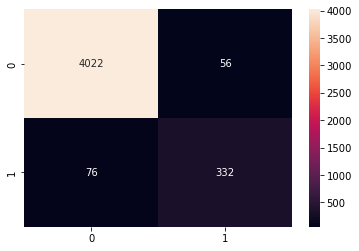

In [56]:
n_classes = 2
base_loss = 'ce'
l=10
print(f'Training model with base loss function {base_loss} and lambda: {l}')
learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
logs.append(learn)

In [58]:
M = np.array([[0,20],
            [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.666436,0.568632,0.951850,0.750000,0.710526,0.794118,0.966053,0.724821,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.273403,0.427738,0.967231,0.824791,0.802784,0.848039,0.976440,0.807101,01:28
1,0.221856,0.359380,0.970129,0.838942,0.823113,0.855392,0.976827,0.822672,01:28
2,0.123698,0.306251,0.971021,0.837500,0.854592,0.821078,0.977450,0.821797,01:28
3,0.033591,0.329164,0.968569,0.818533,0.861789,0.779412,0.977815,0.802587,01:28
4,0.007698,0.332226,0.970798,0.833967,0.863517,0.806373,0.978696,0.818555,01:28


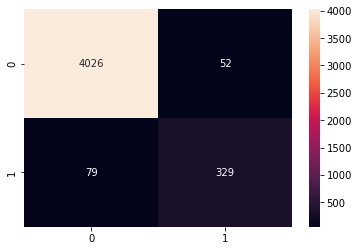

In [59]:
n_classes = 2
base_loss = 'ce'
l=10
print(f'Training model with base loss function {base_loss} and lambda: {l}')
learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
logs.append(learn)

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=2
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.699177,0.575329,0.955863,0.775000,0.722458,0.835784,0.969207,0.753124,01:25


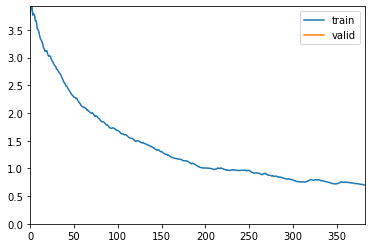

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.279859,0.366395,0.968569,0.833530,0.804100,0.865196,0.982071,0.816869,01:41
1,0.072115,0.293138,0.972136,0.845105,0.854637,0.835784,0.979477,0.829860,01:41


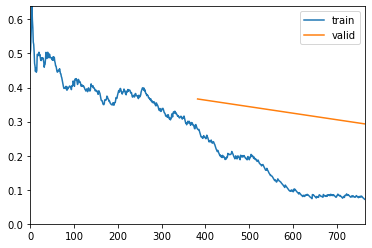

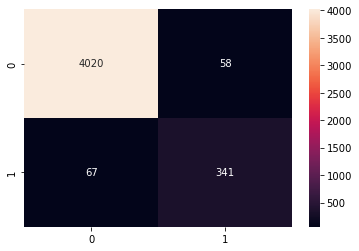

In [95]:
n_classes = 2
base_loss = 'ce'
l=10
print(f'Training model with base loss function {base_loss} and lambda: {l}')
learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)

In [82]:
for l in learners:
    loss = l.recorder.losses
    print(loss)

[]
[]
[]
[]


In [109]:
def train_model(dls, arch=resnet18, loss_func=None, metric = None, epochs=5, wd=None, lr=None):
    losses = []
    mets = []
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
   
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
   
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    
    learn.fine_tune(epochs, lr, cbs=[ShowGraphCallback(), LossRecorder()])
    
    
    return learn

In [115]:
class LossRecorder(Callback):
    def __init__ (self):
        self.losses = []
    def after_epoch(self):
        self.losses.append(self.learn.loss)
    
    

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=2
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.664299,0.667405,0.946277,0.734289,0.667335,0.816176,0.962365,0.709162,01:24


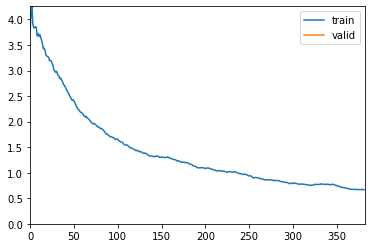

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.297910,0.402133,0.968569,0.836237,0.794702,0.882353,0.978591,0.820277,01:40
1,0.083963,0.302870,0.969906,0.830615,0.850900,0.811275,0.978438,0.814390,01:40


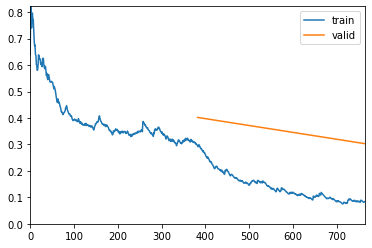

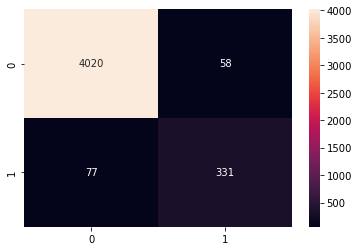

In [116]:
n_classes = 2
base_loss = 'ce'
l=10
print(f'Training model with base loss function {base_loss} and lambda: {l}')
learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)

In [122]:
valid_loss = learn.sched.losses
valid_loss

AttributeError: 'Learner' object has no attribute 'sched'

In [102]:
learn.show_results()

IndexError: list index out of range